<a href="https://colab.research.google.com/github/hashimmg/jax_IB/blob/main/Flapping_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tree_math as tm
import jax
import jax.numpy as jnp
from jax_ib.base import particle_class as pc
from jax_ib.base import grids, fast_diagonalization, boundaries, pressure, diffusion, advection, finite_differences, IBM_Force,convolution_functions,particle_motion, equations
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
import jax_ib
import jax_ib.base as ib
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
import matplotlib.pyplot as plt
import functools as fct
import scipy 
import tree_math
from jax_ib.base import array_utils

In [3]:
import functools
from functools import partial
import jax
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec as P
from jax.experimental.shard_map import shard_map
import numpy as np

In [4]:
mesh2d = jax.make_mesh((4, 2), ('i', 'j'))

In [5]:
density = 1.0    # fluid density
viscosity = 0.05 # fluid viscocity
dt=5e-4          # time step 
num_boundaries = 4
domain = ((0,15.),(0,15.0))
grid = grids.Grid((128,128), domain=domain, device_mesh = mesh2d, periods = (15,15))
bc_fns = [lambda t: 0.0 for _ in range(4)]
vx_bc=((0.0, 0.0), (0.0, 0.0))
vy_bc=((0.0, 0.0), (0.0, 0.0))

velocity_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
               boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vy_bc,bc_fn=bc_fns,time_stamp=0.0))

vx_fn = lambda x, y: jnp.zeros_like(x)
vy_fn = lambda x, y: jnp.zeros_like(x)
vx_0, vy_0 = tuple(
    [
       grids.GridVariable
        (
           grid.eval_on_mesh(fn = lambda x, y: jnp.ones_like(x), offset = offset), bc # initial values for fluid velocities are 0 both in x and y direction
        ) 
        for offset, bc in zip(grid.cell_faces,velocity_bc)
    ]
)
v0 = (vx_0, vy_0)
global_pressure = grids.GridVariable(
    grids.GridArray(jnp.zeros(grid.shape), grid.cell_center, grid), 
    boundaries.get_pressure_bc_from_velocity((vx_0, vy_0)))


subgrid=grid.subgrid((1,1),boundary_layer_widths=(1,1))

In [94]:
def add_halo_layer(array):
    I, J = jax.lax.psum(1, 'i'), jax.lax.psum(1, 'j')
    left_halo = jax.lax.ppermute(array[:,-1], 'j', [(j, (j + 1) % J) for j in range(J)])
    right_halo = jax.lax.ppermute(array[:,0], 'j', [(j, (j - 1) % J) for j in range(J)])
    upper_halo = jax.lax.ppermute(array[-1,:], 'i', [(i, (i + 1) % I) for i in range(I)])
    lower_halo = jax.lax.ppermute(array[0,:], 'i', [(i, (i - 1) % I) for i in range(I)])
    
    upper_halo = jnp.append(0.0, jnp.append(upper_halo, 0.0))
    lower_halo = jnp.append(0.0, jnp.append(lower_halo, 0.0))
    
    temp = jnp.concatenate([left_halo[:,None], array, right_halo[:,None]], axis=1)
    return  jnp.concatenate([upper_halo[None, :], temp, lower_halo[None,:]], axis=0)

def convect(v):
    return tuple(advection.advect_upwind(u, v, dt) for u in v)

# we assume all subgrids have identical shapes and steps
def get_subgrid_laplacians(grid, boundary_layer_widths):
    subgrid = grid.subgrid((1,1), boundary_layer_widths)
    return tuple([jnp.array(a) for a in list(map(array_utils.laplacian_matrix,subgrid.shape, subgrid.step))])

####################################################################
# pinv causes some unwanted device-to-device comms at the moment, see fast_diagonalization.py line 213.
# `apply` is a non-pure function depending on `diagonals` which currently lives on device cuda:0
boundary_layer_widths = (0,0)
laplacians = get_subgrid_laplacians(grid, boundary_layer_widths)
#pinv = fast_diagonalization.pseudoinverse(
#    laplacians,global_pressure.array.data.dtype, 
#    hermitian=True,circulant=True,implementation=None)
#pinv(np.ones((laplacians[0].shape[0], laplacians[1].shape[0])).astype(np.float32))
####################################################################

cutoff = 10 * jnp.finfo(jnp.float32).eps
def func(v):                                                                                                                                                                          
    with np.errstate(divide='ignore', invalid='ignore'):                                                                                                                                
        return np.where(abs(v) > cutoff, 1 / v, 0)  
eigenvalues = ([np.fft.fft(op[:, 0]) for op in laplacians[:-1]]+ [np.fft.rfft(laplacians[-1][:, 0])]) 
summed_eigenvalues = functools.reduce(np.add.outer, eigenvalues)                                                                                                                      
diagonals = jnp.asarray(func(summed_eigenvalues).real) 

def ellipse(geometry_params, ntheta=200):
    A = geometry_params[0]
    B = geometry_params[1]
    xt = jnp.linspace(-A,A,ntheta)
    yt = B/A*jnp.sqrt(A**2-xt**2)
    xt_2 = jnp.linspace(A,-A,ntheta)[1:-1]
    yt2 = -B/A*jnp.sqrt(A**2-xt_2**2)
    return jnp.append(xt,xt_2),jnp.append(yt,yt2)

def ellipse_trajectory(ellipse_parameters, initial_center_of_mass_position, angular_rotation_speed, 
                       center_of_mass_motion_parameters, t):
    x, y = ellipse(ellipse_parameters, 200)
    amplitude, frequency = center_of_mass_motion_parameters
    center_of_mass = initial_center_of_mass_position - jnp.array([amplitude * jnp.sin(2*jnp.pi*frequency*t), 0.0])
    xp = x*jnp.cos(angular_rotation_speed*t)-y*jnp.sin(angular_rotation_speed*t)+center_of_mass[0]                                                                                  
    yp = x*jnp.sin(angular_rotation_speed*t)+y*jnp.cos(angular_rotation_speed*t)+center_of_mass[1] 
    return xp, yp    

surf_fn =  lambda field,xp,yp:convolution_functions.convolve(field,xp,yp,convolution_functions.gaussian)

@partial(shard_map, mesh=mesh2d, in_specs=(P('i','j'),(P('i','j'), P('i','j')), None,None,P(),None, P()), 
         out_specs=(P('i','j'), P('i','j')))
def evolve_navier_stokes(pressure_field, velocities, grid, boundary_layer_widths, diags, num_steps,dt):
    #create a subgrid for the current patch
    i = jax.lax.axis_index('i')
    j = jax.lax.axis_index('j')
    subgrid = grid.subgrid((i,j), boundary_layer_widths=boundary_layer_widths)
    explicit_update = equations.navier_stokes_explicit_terms(
        density=1.0, viscosity=1.0, dt=5E-4,grid=subgrid, convect=convect, diffuse=diffusion.diffuse, forcing=None)
    
    def pinv(rhs):                                                                                                                                                       
        return jnp.fft.irfftn(diags * jnp.fft.rfftn(rhs)).astype(jnp.float32)
      
    # hard coded boundary condition values in each direction
    bc_fns = [lambda t: 0.0 for _ in range(4)]
    ux_bc=((0.0, 0.0), (0.0, 0.0))
    uy_bc=((0.0, 0.0), (0.0, 0.0))
    pressure_bc = ((0.0, 0.0), (0.0, 0.0))
    
    pressure_bc = boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=pressure_bc,bc_fn=bc_fns,time_stamp=0.0)
    velocity_bcs = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=ux_bc,bc_fn=bc_fns,time_stamp=0.0),
                    boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=uy_bc,bc_fn=bc_fns,time_stamp=0.0))
    
    ux, uy = velocities
    ux_trajectory = []
    uy_trajectory = []
    pressure_trajectory = []
    for step in range(num_steps):
        t = step * dt
        local_pressure = pressure_field #add_halo_layer(pressure_field)
        local_ux = ux#add_halo_layer(ux)
        local_uy = uy#add_halo_layer(uy)
        
        #wrap into GridVariable to make jax_ib happy 
        local_pressure = grids.GridVariable(grids.GridArray(local_pressure, subgrid.cell_center, subgrid), pressure_bc)
        local_ux = grids.GridVariable(grids.GridArray(local_ux, subgrid.cell_faces[0], subgrid), velocity_bcs[0])
        local_uy = grids.GridVariable(grids.GridArray(local_uy, subgrid.cell_faces[1], subgrid), velocity_bcs[1])
    
        explicit = explicit_update((local_ux, local_uy))
        dP = finite_differences.forward_difference(local_pressure)

        local_u_star = tuple([u.array.data + dt * e.array.data - dp.data for u, e, dp in zip((local_ux, local_uy), explicit, dP)])
        local_u_star = tuple([grids.GridVariable(grids.GridArray(u, os, subgrid), bc) for os, u, bc in zip(subgrid.cell_faces, local_u_star, velocity_bcs)])
        forces = IBM_Force.immersed_boundary_force(
            local_u_star,[ellipse_position],convolution_functions.gaussian,surf_fn, t, dt)
      
        local_u_star_star = tuple([u.array.data + dt * force.array.data for u, force in zip(local_u_star, forces)])
        local_u_star_star = tuple([grids.GridVariable(grids.GridArray(u, offset, subgrid), bc) for u, bc, offset in zip(local_u_star_star, velocity_bcs, subgrid.cell_faces)])
        local_u_final, new_local_pressure= pressure.projection_and_update_pressure_pinv(local_pressure, local_u_star_star, pinv)
        
        ux = local_u_final[0].array.data#[1:-1,1:-1]
        uy = local_u_final[1].array.data#[1:-1,1:-1]
        
        pressure_field = new_local_pressure.array.data#[1:-1,1:-1]
        ux_trajectory.append(ux)
        uy_trajectory.append(uy)
        pressure_trajectory.append(pressure_field)
    return jnp.stack(ux_trajectory, axis=2), jnp.stack(uy_trajectory, axis=2)





In [95]:
particle_geometry_param = jnp.array([[0.1,0.5]])
particle_center_position = jnp.array([[domain[0][1]*0.75,domain[1][1]*0.5]]) #could be an array for multiple objects

displacement_param = jnp.array([[2.8,0.25]])
rotation_param = jnp.array([0.0*jnp.pi/2])

ellipse_position = fct.partial(ellipse_trajectory, *[particle_geometry_param[0],particle_center_position[0], rotation_param[0], 
                                                     displacement_param[0]])
grad_ellipse_position = jax.jacrev(ellipse_position)


In [96]:

subgrid_laplacians = get_subgrid_laplacians(grid, boundary_layer_widths)
y = evolve_navier_stokes(global_pressure.array.data, (vx_0.array.data, vy_0.array.data), 
                         grid,boundary_layer_widths, diagonals, 10, 1E-3)
print('FINAL RESULT:\n', y)

FINAL RESULT:
 (Array([[[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ]],

       [[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 1.        ,  1.        ,  1.

In [85]:
ux, uy = y


In [86]:
ux, uy = np.array(y[0]), np.array(y[1])

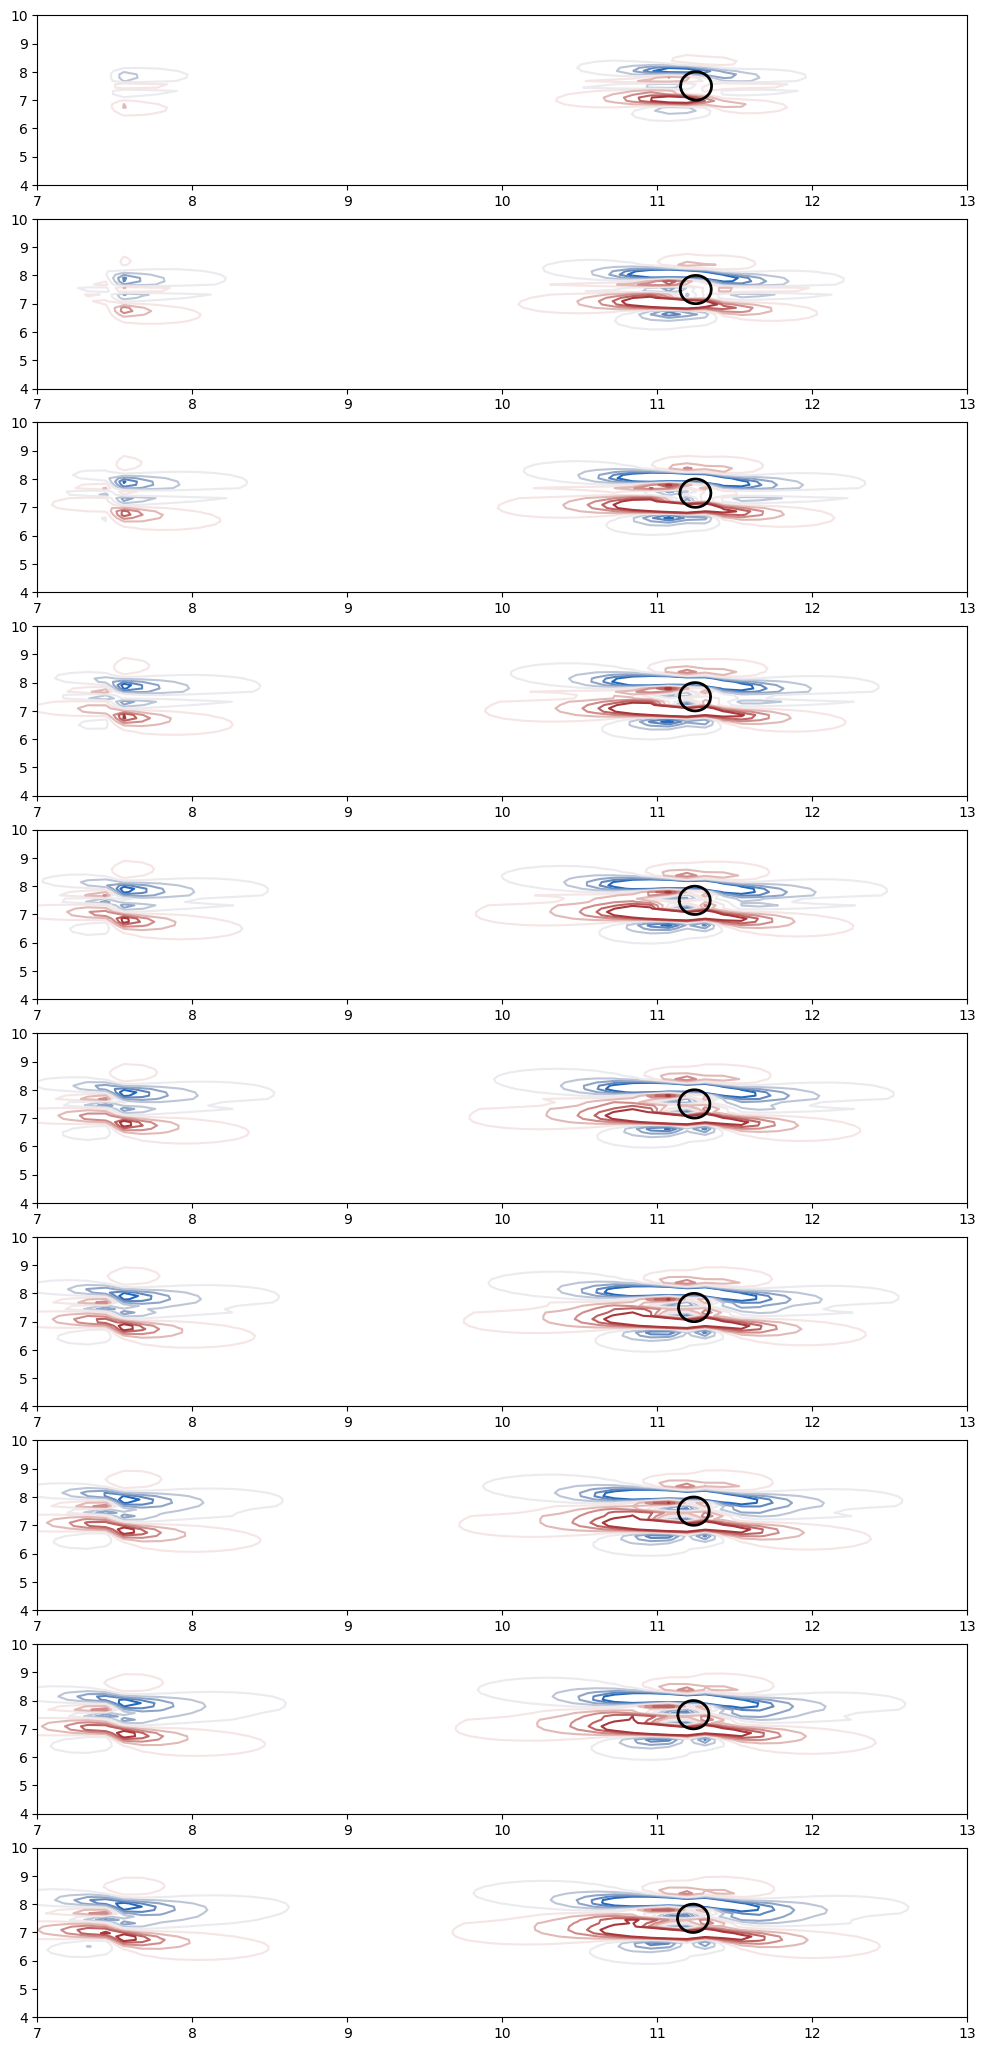

In [89]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

X,Y = grid.mesh(grid.cell_center)



def calc_vorticity(vx, vy):
    vel_bc = (boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0),
              boundaries.new_periodic_boundary_conditions(ndim=2,bc_vals=vx_bc,bc_fn=bc_fns,time_stamp=0.0))


    velocity = tuple([grids.GridVariable(grids.GridArray(u,offset, grid), bc) for u, offset, bc in zip((vx, vy), grid.cell_faces, vel_bc)])
    return finite_differences.central_difference(velocity[1], axis=1).data- finite_differences.central_difference(velocity[0], axis=1).data



fig,ax = plt.subplots(figsize=(12,26),nrows=ux.shape[2])

t = np.arange(ux.shape[2])*dt
counter=0
for idx in range(ux.shape[2]):
    ax[counter].contour(X,Y,calc_vorticity(ux[:,:,idx], uy[:,:,idx]),cmap=seaborn.color_palette("vlag", as_cmap=True),levels=np.linspace(-10, 10, 10))
    xp, yp = ellipse_position(t[idx])
    ax[counter].set_xlim([7,13])
    ax[counter].set_ylim([4,10])
    ax[counter].plot(xp,yp,'k-',linewidth=2.0)
    counter+=1

In [84]:
idx = 4
vort = calc_vorticity(ux[:,:,idx], uy[:,:,idx])
vort[np.abs(vort) > 1E-4]

Array([], shape=(0,), dtype=float32)

In [76]:
ux[0] - uy[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)